BTC-ETH PAIRS TRADING RESEARCH
Hypothesis: BTC-ETH exhibit cointegrated relationship suitable for pairs trading
Timeframe: Daily (aggregated from 5-minute data)
Regression window: 504 days (~2.0 years)

Loading BTCUSD...
  Loaded 3517 daily observations from 2016-01-01 00:00:00 to 2025-08-17 00:00:00
Loading ETHUSD...
  Loaded 3374 daily observations from 2016-05-23 00:00:00 to 2025-08-17 00:00:00
Common data period: 2016-05-23 00:00:00 to 2025-08-17 00:00:00
Total observations: 3,374

COINTEGRATION ANALYSIS (BTC vs ETH Prices)
Cointegration Statistic: -1.9176
Cointegration p-value: 0.571043
Critical Value (1%): -3.8997
Critical Value (5%): -3.3379
Are Cointegrated: False
✗ NO COINTEGRATION - Pairs trading not recommended

Computing spread formulations...
Computing rolling regression spread (window=504)...

SPREAD FORMULATION ANALYSIS

RATIO_SPREAD:
  Observations: 3,374
  Mean: 28.481960
  Std: 17.718610
  Range: [6.747410, 129.210526]
  ADF Statistic: -2.5470
  ADF p-value: 0.104443


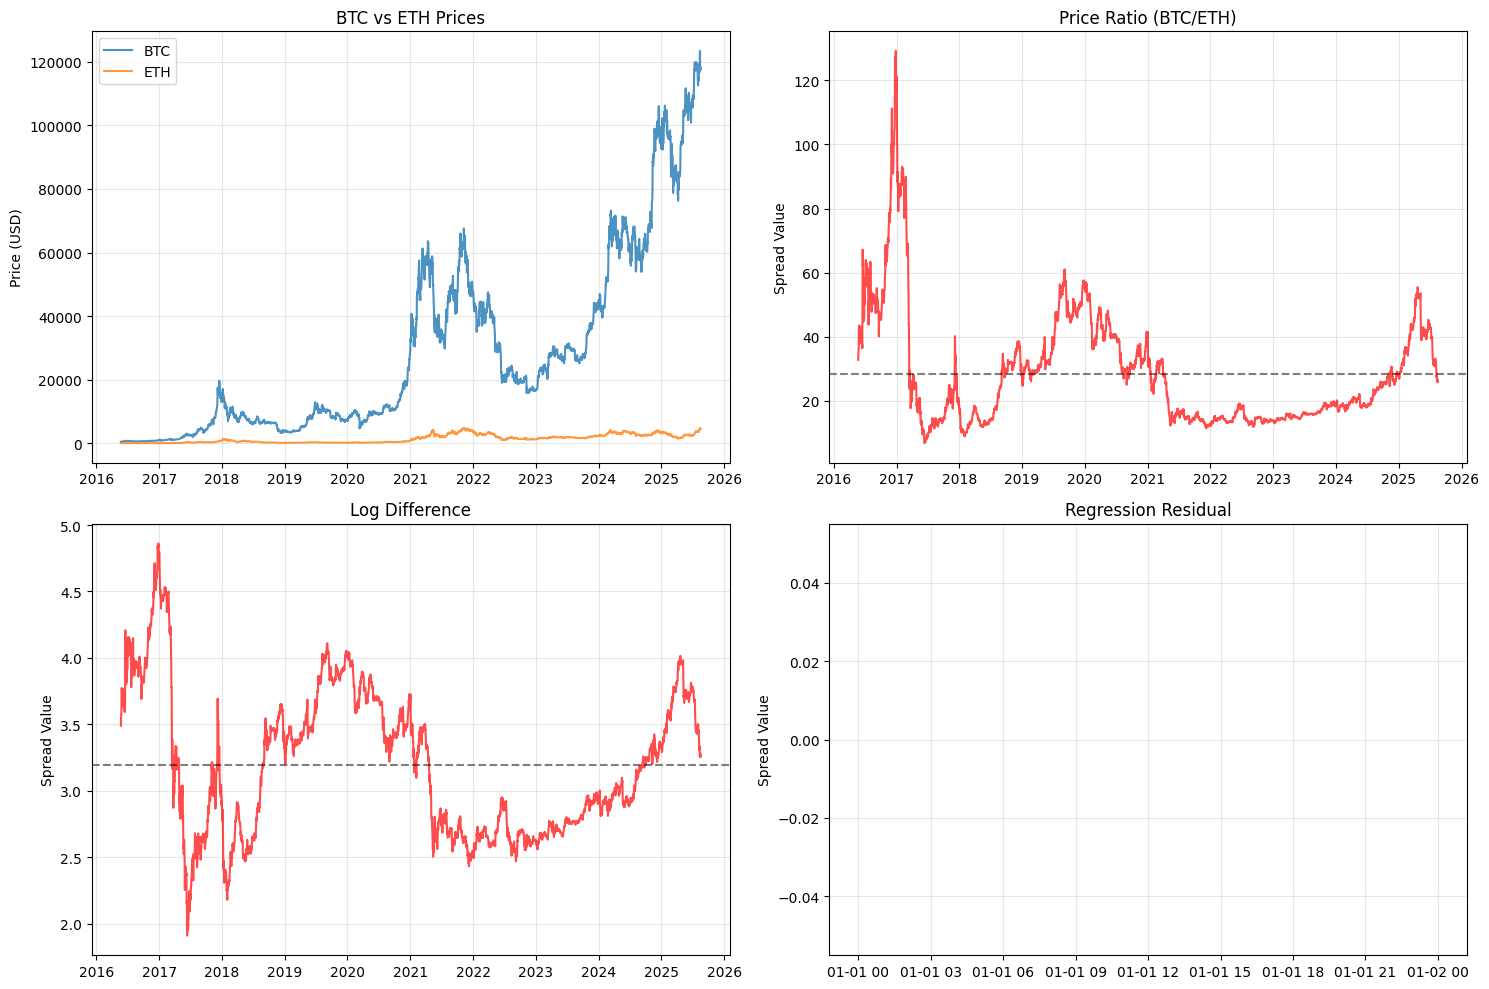

In [14]:
"""
BTC-ETH Pairs Trading Research

HYPOTHESIS: 
BTC and ETH exhibit a long-term equilibrium relationship that can be exploited 
through mean-reverting spread strategies.

METHODOLOGY:
1. Focus on BTC-ETH pair only (simplest case)
2. Test multiple spread formulations for cointegration:
   - Price ratio (BTC/ETH)
   - Log price difference (log(BTC) - log(ETH))
   - Regression-based residual spread
3. Use daily timeframe initially (reduces noise, captures meaningful moves)
4. Only proceed if cointegration is established

TIME FRAME RATIONALE:
- Daily: Captures fundamental relationship while filtering intraday noise
- Allows for realistic execution and transaction costs
- Sufficient history for robust statistical testing
"""

import pandas as pd
import numpy as np
from pathlib import Path
import warnings
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.api import OLS, add_constant
from typing import Tuple, Dict, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

warnings.filterwarnings('ignore')

# Configuration
DATA_DIR = Path("coinbase/5m")
SYMBOLS = ['BTCUSD', 'ETHUSD']  # Start simple: BTC-ETH only
SIGNIFICANCE_LEVEL = 0.05
REGRESSION_WINDOW = 504  # ~2 years of daily data (252 trading days * 2)

def load_crypto_data(symbol: str) -> pd.DataFrame:
    """
    Load and aggregate 5-minute data to daily for a single symbol.
    
    Args:
        symbol: Crypto symbol to load
        
    Returns:
        DataFrame with daily OHLCV data
    """
    print(f"Loading {symbol}...")
    
    all_files = []
    for year_dir in DATA_DIR.iterdir():
        if year_dir.is_dir():
            file_path = year_dir / f"{symbol}_5m_{year_dir.name}.csv"
            if file_path.exists():
                all_files.append(file_path)
    
    if not all_files:
        raise FileNotFoundError(f"No data files found for {symbol}")
    
    # Load all files
    dfs = []
    for file_path in all_files:
        df = pd.read_csv(
            file_path, 
            header=None, 
            names=['timestamp', 'open', 'high', 'low', 'close', 'volume']
        )
        df = df.dropna()
        dfs.append(df)
    
    # Combine all years
    combined = pd.concat(dfs, ignore_index=True)
    combined['timestamp'] = pd.to_datetime(combined['timestamp'], unit='s')
    combined = combined.sort_values('timestamp').reset_index(drop=True)
    
    # Aggregate to daily
    combined['date'] = combined['timestamp'].dt.date
    daily = combined.groupby('date').agg({
        'open': 'first',
        'high': 'max', 
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }).reset_index()
    
    daily['date'] = pd.to_datetime(daily['date'])
    
    print(f"  Loaded {len(daily)} daily observations from {daily['date'].min()} to {daily['date'].max()}")
    
    return daily

def test_stationarity(series: pd.Series, name: str) -> Dict:
    """
    Test stationarity using ADF test.
    
    Args:
        series: Time series to test
        name: Name for reporting
        
    Returns:
        Dictionary with test results
    """
    # Remove any infinite or NaN values
    clean_series = series.dropna()
    clean_series = clean_series[np.isfinite(clean_series)]
    
    if len(clean_series) < 50:
        return {'name': name, 'adf_stat': None, 'adf_pvalue': None, 'is_stationary': False}
    
    try:
        adf_stat, adf_pvalue, _, _, critical_values, _ = adfuller(clean_series, autolag='AIC')
        is_stationary = adf_pvalue < SIGNIFICANCE_LEVEL
        
        return {
            'name': name,
            'adf_stat': adf_stat,
            'adf_pvalue': adf_pvalue,
            'critical_1pct': critical_values['1%'],
            'critical_5pct': critical_values['5%'],
            'is_stationary': is_stationary,
            'n_obs': len(clean_series)
        }
    except Exception as e:
        print(f"ADF test failed for {name}: {e}")
        return {'name': name, 'adf_stat': None, 'adf_pvalue': None, 'is_stationary': False}

def test_cointegration(series1: pd.Series, series2: pd.Series, name: str) -> Dict:
    """
    Test cointegration between two series using Engle-Granger test.
    
    Args:
        series1, series2: Time series to test
        name: Name for reporting
        
    Returns:
        Dictionary with cointegration test results
    """
    # Align series
    aligned = pd.concat([series1, series2], axis=1).dropna()
    
    if len(aligned) < 50:
        return {'name': name, 'coint_stat': None, 'coint_pvalue': None, 'is_cointegrated': False}
    
    try:
        coint_stat, coint_pvalue, critical_values = coint(aligned.iloc[:, 0], aligned.iloc[:, 1])
        is_cointegrated = coint_pvalue < SIGNIFICANCE_LEVEL
        
        return {
            'name': name,
            'coint_stat': coint_stat,
            'coint_pvalue': coint_pvalue,
            'critical_1pct': critical_values[0],
            'critical_5pct': critical_values[1],
            'is_cointegrated': is_cointegrated,
            'n_obs': len(aligned)
        }
    except Exception as e:
        print(f"Cointegration test failed for {name}: {e}")
        return {'name': name, 'coint_stat': None, 'coint_pvalue': None, 'is_cointegrated': False}

def compute_spread_formulations(btc_prices: pd.Series, eth_prices: pd.Series) -> pd.DataFrame:
    """
    Compute different spread formulations for BTC-ETH.
    
    Args:
        btc_prices, eth_prices: Price series
        
    Returns:
        DataFrame with different spread formulations
    """
    # Align the data
    combined = pd.concat([btc_prices, eth_prices], axis=1, keys=['BTC', 'ETH']).dropna()
    
    spreads = pd.DataFrame(index=combined.index)
    
    # 1. Price ratio (BTC/ETH)
    spreads['ratio_spread'] = combined['BTC'] / combined['ETH']
    
    # 2. Log price difference (log(BTC) - log(ETH))
    spreads['log_diff_spread'] = np.log(combined['BTC']) - np.log(combined['ETH'])
    
    # 3. Regression-based spread (rolling window)
    spreads['regression_spread'] = compute_regression_spread(combined['BTC'], combined['ETH'])
    
    return spreads

def compute_regression_spread(btc_prices: pd.Series, eth_prices: pd.Series, 
                            window: int = REGRESSION_WINDOW) -> pd.Series:
    """
    Compute regression-based spread using rolling window.
    Spread = BTC - (alpha + beta * ETH)
    
    Args:
        btc_prices, eth_prices: Price series
        window: Rolling regression window
        
    Returns:
        Series of regression residuals (spread)
    """
    residuals = pd.Series(index=btc_prices.index, dtype=float)
    
    print(f"Computing rolling regression spread (window={window})...")
    
    for i in range(window, len(btc_prices)):
        # Rolling window data
        y = btc_prices.iloc[i-window:i]
        X = add_constant(eth_prices.iloc[i-window:i])
        
        try:
            # Fit regression
            model = OLS(y, X).fit()
            
            # Compute residual for current observation
            current_X = add_constant(eth_prices.iloc[i])
            predicted = model.predict(current_X)
            residual = btc_prices.iloc[i] - predicted[0]
            
            residuals.iloc[i] = residual
            
        except Exception:
            residuals.iloc[i] = np.nan
    
    return residuals

def analyze_spread_properties(spreads_df: pd.DataFrame) -> Dict:
    """
    Analyze statistical properties of different spread formulations.
    
    Args:
        spreads_df: DataFrame with different spread formulations
        
    Returns:
        Dictionary with analysis results
    """
    results = {}
    
    print("\n" + "="*80)
    print("SPREAD FORMULATION ANALYSIS")
    print("="*80)
    
    for spread_name in spreads_df.columns:
        spread_series = spreads_df[spread_name].dropna()
        
        if len(spread_series) < 50:
            continue
            
        # Basic statistics
        mean_val = spread_series.mean()
        std_val = spread_series.std()
        min_val = spread_series.min()
        max_val = spread_series.max()
        
        # Stationarity test
        stationarity = test_stationarity(spread_series, spread_name)
        
        results[spread_name] = {
            'mean': mean_val,
            'std': std_val,
            'min': min_val,
            'max': max_val,
            'n_obs': len(spread_series),
            'stationarity': stationarity
        }
        
        print(f"\n{spread_name.upper()}:")
        print(f"  Observations: {len(spread_series):,}")
        print(f"  Mean: {mean_val:.6f}")
        print(f"  Std: {std_val:.6f}")
        print(f"  Range: [{min_val:.6f}, {max_val:.6f}]")
        print(f"  ADF Statistic: {stationarity['adf_stat']:.4f}")
        print(f"  ADF p-value: {stationarity['adf_pvalue']:.6f}")
        print(f"  Is Stationary: {stationarity['is_stationary']}")
        
        if stationarity['is_stationary']:
            print(f"  ✓ STATIONARY SPREAD FOUND!")
        else:
            print(f"  ✗ Non-stationary")
    
    return results

def test_price_cointegration(btc_prices: pd.Series, eth_prices: pd.Series) -> Dict:
    """
    Test cointegration between BTC and ETH prices directly.
    
    Args:
        btc_prices, eth_prices: Price series
        
    Returns:
        Cointegration test results
    """
    print("\n" + "="*80)
    print("COINTEGRATION ANALYSIS (BTC vs ETH Prices)")
    print("="*80)
    
    # Test cointegration
    coint_result = test_cointegration(btc_prices, eth_prices, "BTC_ETH_prices")
    
    print(f"Cointegration Statistic: {coint_result['coint_stat']:.4f}")
    print(f"Cointegration p-value: {coint_result['coint_pvalue']:.6f}")
    print(f"Critical Value (1%): {coint_result['critical_1pct']:.4f}")
    print(f"Critical Value (5%): {coint_result['critical_5pct']:.4f}")
    print(f"Are Cointegrated: {coint_result['is_cointegrated']}")
    
    if coint_result['is_cointegrated']:
        print("✓ COINTEGRATION DETECTED - Pairs trading viable!")
    else:
        print("✗ NO COINTEGRATION - Pairs trading not recommended")
    
    return coint_result

def plot_spreads(spreads_df: pd.DataFrame, btc_prices: pd.Series, eth_prices: pd.Series):
    """
    Plot the different spread formulations and price series.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot price series
    axes[0, 0].plot(btc_prices.index, btc_prices.values, label='BTC', alpha=0.8)
    axes[0, 0].plot(eth_prices.index, eth_prices.values, label='ETH', alpha=0.8)
    axes[0, 0].set_title('BTC vs ETH Prices')
    axes[0, 0].set_ylabel('Price (USD)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot spread formulations
    spread_names = ['ratio_spread', 'log_diff_spread', 'regression_spread']
    titles = ['Price Ratio (BTC/ETH)', 'Log Difference', 'Regression Residual']
    
    for i, (spread_name, title) in enumerate(zip(spread_names, titles)):
        if spread_name in spreads_df.columns:
            row, col = (0, 1) if i == 0 else (1, i-1)
            
            spread_data = spreads_df[spread_name].dropna()
            axes[row, col].plot(spread_data.index, spread_data.values, color='red', alpha=0.7)
            axes[row, col].axhline(y=spread_data.mean(), color='black', linestyle='--', alpha=0.5)
            axes[row, col].set_title(title)
            axes[row, col].set_ylabel('Spread Value')
            axes[row, col].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main():
    """
    Main analysis pipeline.
    """
    print("BTC-ETH PAIRS TRADING RESEARCH")
    print("="*50)
    print(f"Hypothesis: BTC-ETH exhibit cointegrated relationship suitable for pairs trading")
    print(f"Timeframe: Daily (aggregated from 5-minute data)")
    print(f"Regression window: {REGRESSION_WINDOW} days (~{REGRESSION_WINDOW/252:.1f} years)")
    print()
    
    # 1. Load data
    try:
        btc_data = load_crypto_data('BTCUSD')
        eth_data = load_crypto_data('ETHUSD') 
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        return
    
    # 2. Align data on common dates
    btc_data.set_index('date', inplace=True)
    eth_data.set_index('date', inplace=True)
    
    # Rename columns before joining to avoid conflicts
    btc_close = btc_data[['close']].rename(columns={'close': 'close_BTC'})
    eth_close = eth_data[['close']].rename(columns={'close': 'close_ETH'})
    common_data = btc_close.join(eth_close, how='inner')
    
    if len(common_data) < 100:
        print("Insufficient overlapping data between BTC and ETH")
        return
    
    print(f"Common data period: {common_data.index.min()} to {common_data.index.max()}")
    print(f"Total observations: {len(common_data):,}")
    
    btc_prices = common_data['close_BTC']
    eth_prices = common_data['close_ETH']
    
    # 3. Test price cointegration first
    coint_result = test_price_cointegration(btc_prices, eth_prices)
    
    # 4. Compute different spread formulations
    print("\nComputing spread formulations...")
    spreads = compute_spread_formulations(btc_prices, eth_prices)
    
    # 5. Analyze spread properties
    spread_analysis = analyze_spread_properties(spreads)
    
    # 6. Summary and conclusions
    print("\n" + "="*80)
    print("RESEARCH CONCLUSIONS")
    print("="*80)
    
    # Check if any approach shows promise
    cointegrated = coint_result['is_cointegrated']
    stationary_spreads = [name for name, results in spread_analysis.items() 
                         if results['stationarity']['is_stationary']]
    
    print(f"Price Cointegration: {'YES' if cointegrated else 'NO'}")
    print(f"Stationary Spreads: {len(stationary_spreads)}")
    
    if stationary_spreads:
        print("Stationary spread formulations found:")
        for spread_name in stationary_spreads:
            results = spread_analysis[spread_name]
            print(f"  - {spread_name}: ADF p-value = {results['stationarity']['adf_pvalue']:.6f}")
    
    if cointegrated or stationary_spreads:
        print("\n✓ PROCEED: Statistical evidence supports pairs trading approach")
        print("Next steps:")
        print("  1. Develop entry/exit rules based on spread z-scores")
        print("  2. Implement backtesting framework")
        print("  3. Add transaction costs and realistic execution assumptions")
        print("  4. Expand to other crypto pairs if successful")
    else:
        print("\n✗ STOP: No statistical evidence for mean-reverting relationship")
        print("Consider alternative strategies:")
        print("  1. Momentum-based approaches")
        print("  2. Different timeframes (weekly, monthly)")
        print("  3. Different asset pairs")
        print("  4. Factor-based models instead of pairs trading")
    
    # 7. Visualization
    print("\nGenerating plots...")
    plot_spreads(spreads, btc_prices, eth_prices)
    
    return {
        'cointegration': coint_result,
        'spread_analysis': spread_analysis,
        'spreads_data': spreads,
        'price_data': common_data
    }

if __name__ == "__main__":
    results = main()